In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import EarthLocation
from astropy.time import Time

from astroplan.plots import plot_airmass
from matplotlib import pyplot as plt
%matplotlib inline

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import Duration
from pocs.utils.config import load_config

config = load_config()

/home/wtgee/miniconda/lib/python3.5/site-packages/PIL/Image.py:84: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/home/wtgee/miniconda/lib/python3.5/site-packages/PIL/Image.py:84: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


In [3]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Tonight for the observer
tonight = observer.tonight(horizon=-18 * u.degree)
sunset = tonight[0]
sunrise = tonight[1]

In [4]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

In [5]:
for obs in scheduler.observations.values():
    print(obs)

M44: 120.0 s exposures in blocks of 10, minimum 60, priority 50
M42: 240.0 s exposures in blocks of 10, minimum 60, priority 25
Tres 3: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 189733: 120.0 s exposures in blocks of 10, minimum 60, priority 100
M5: 120.0 s exposures in blocks of 10, minimum 60, priority 50
KIC 8462852: 60.0 s exposures in blocks of 15, minimum 45, priority 50


In [6]:
# Get the best observations for the entire night - show_all returns entire list along with score
best = scheduler.get_observation(show_all=True, time=sunset)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: HD 189733    Merit: 101.23554877335091
Field: KIC 8462852  Merit: 51.24343304152418


Corresponding Log:
```
Checking Constraint: Duration above 30.0 deg
  Observation: Wasp 33
          Score: 0.0      Veto: True
          Wasp 33 vetoed by Duration above 30.0 deg
  Observation: HD 189733
      Target passes meridian before sunrise, using meridian
          Score: 0.2355514696540074       Veto: False
  Observation: HD 209458
          Score: 0.0      Veto: True
          HD 209458 vetoed by Duration above 30.0 deg
  Observation: M42
          Score: 0.0      Veto: True
          M42 vetoed by Duration above 30.0 deg
  Observation: Tres 3
      Target passes meridian before sunrise, using meridian
          Score: 0.045907440364313885     Veto: True
          Tres 3 vetoed by Duration above 30.0 deg
  Observation: KIC 8462852
      Target passes meridian before sunrise, using meridian
          Score: 0.24343519946493689      Veto: False
  Observation: M5
          Score: 0.16638248243821135      Veto: True
          M5 vetoed by Duration above 30.0 deg
  Observation: M44
          Score: 0.0      Veto: True
          M44 vetoed by Duration above 30.0 deg
```

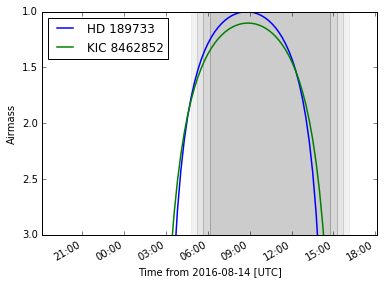

In [7]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, sunset, 
             brightness_shading=True)
        
plt.legend(loc=2)

plt.show()

In [8]:
# Set a later time to start
t2 = sunrise - 3 * u.hour

# Get the best observations for the entire night
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Wasp 33      Merit: 101.6090850288856
Field: HD 209458    Merit: 101.58536711227553
Field: KIC 8462852  Merit: 51.27292162725647


Corresponding Log:
```
 Checking Constraint: Duration above 30.0 deg
   Observation: Wasp 33
       Target passes meridian before sunrise, using meridian
           Score: 0.6090868054314647       Veto: False
   Observation: HD 189733
           Score: 0.23391792209202023      Veto: True
           HD 189733 vetoed by Duration above 30.0 deg
   Observation: HD 209458
           Score: 0.5853689900675003       Veto: False
   Observation: M42
           Score: 0.0      Veto: True
           M42 vetoed by Duration above 30.0 deg
   Observation: Tres 3
           Score: 0.0      Veto: True
           Tres 3 vetoed by Duration above 30.0 deg
   Observation: KIC 8462852
           Score: 0.27292491706882427      Veto: False
   Observation: M5
           Score: 0.0      Veto: True
           M5 vetoed by Duration above 30.0 deg
   Observation: M44
           Score: 0.0      Veto: True
           M44 vetoed by Duration above 30.0 deg
```

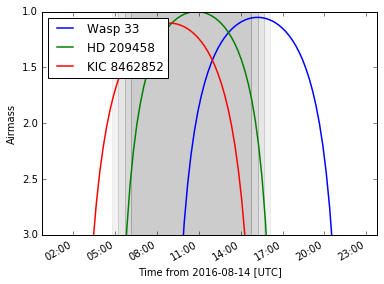

In [9]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
        
plt.legend(loc=2)

plt.show()